In [1]:
import os
import sys

sys.path.append("../bottlenecks")
import configs
from data_utils import *
from graph_plot_tools import *
from utils import *
from cbm import *

In [10]:
configs.set_seed(42)
device = configs.set_device(0)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# we use CUB200 example

with open("../data/conceptnet_cub200_filtered_new.txt", "r") as f:
    concepts = f.read().split('\n')

preprocess data

In [4]:
train_loader_preprocessed  = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="train")

val_loader_preprocessed = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="val")

test_loader_preprocessed = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="test")

2024-02-04 09:07:05.860311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 09:07:05.860418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 09:07:05.874919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-04 09:07:06.729586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 09:07:10.277433: W tensorflow/compiler/

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

configure nets

In [14]:
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
nets = []

#openai/clip-vit-large-patch14
for _ in range(2):
    nets.append(
        SparseCBLmodel_for_logits(num_concepts=len(concepts), num_classes=200, model_name="openai/clip-vit-base-patch32")
    )
    nets[-1].zero_grad()
    nets[-1].train()

criterion = nn.CrossEntropyLoss()

choose optimizers for each of tainable layers

In [15]:
opts = []
for i in range(1):
    opts += [
        (optim.Adam(nets[i * 2 + 0].cbl.parameters(), lr=0.0001),
         optim.Adam(nets[i * 2 + 0].head.parameters(), lr=0.0001)),
        
        (optim.Adam(nets[i * 2 + 1].cbl.parameters(), lr=0.0003), 
         optim.Adam(nets[i * 2 + 1].head.parameters(), lr=0.0003)),
         ]

opt_names = [
    "Adam, 0.0001, bs_mul = 1",
    #"AdamW, 0.001, bs_mul = 1",
    "Adam, 0.0003, bs_mul = 1",
] * 1

In [16]:
bs_muls = [
    1, 1,
] * 1

In [17]:
lr_decay =1 # use any you want

In [18]:
'''initialize history'''

hist = []

for (net, optimizer, opt_name, bs_mul) in zip(nets, opts, opt_names, bs_muls):
    net.to(device)
    hist.append({
        "task_name": "Bottleneck Training",
        "name": opt_name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_cbl_loss": [], "val_cbl_loss": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

In [12]:
# load metrics

precision_metric = load_metric('precision')
recall_metric = load_metric('recall')
f1_metric = load_metric('f1')

/tmp/ipykernel_1007632/2648392620.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  precision_metric = load_metric('precision')


## sparse model training

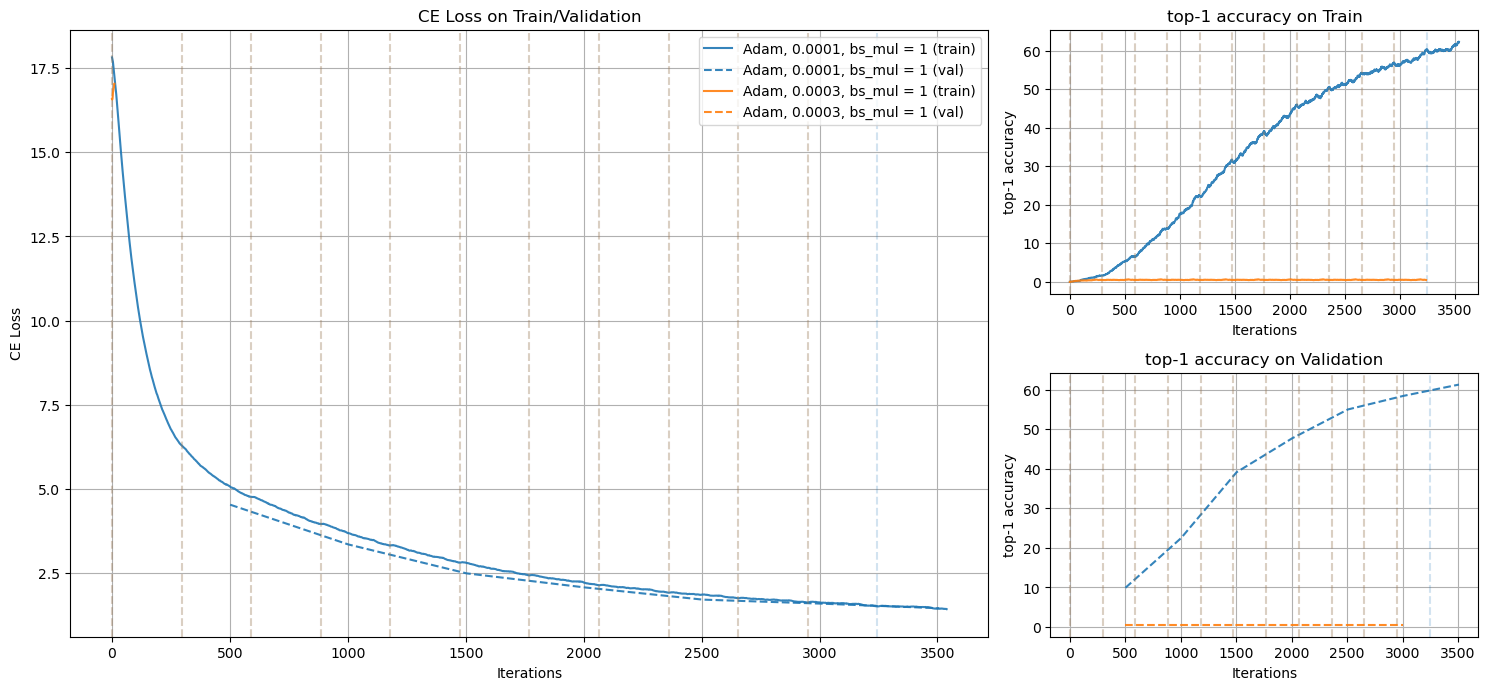

Finished Training


In [21]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "GumbleTraining"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_gumbel(cbl_logits)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_gumbel(cbl_logits)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

## l1 model training

In [ ]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "L1Training"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_l1(net) / len(concepts)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_l1(net) / len(concepts)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

## contrastive model training

In [ ]:
from IPython import display

num_epochs = 10
batch_mul_step_count = 500
norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "ContrastiveTraining"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(num_epochs):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_cbl(cbl_logits)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_cbl(cbl_logits)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

## test performance

In [ ]:
import warnings

for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                for step, batch in enumerate(test_loader_preprocessed, 0):
                    warnings.filewarnings('ignore')
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    cbl_logits, logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))
            
            torch.save({
                f'{round(net_hist["test_acc_top_1"][-1], 2)}_model': net.state_dict
                }, os.path.join(loading_path, f'{round(net_hist["test_acc_top_1"][-1], 2)}_model.bin')
            )